### segment waveform into individual syllables using dynamic thresholding
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import pandas as pd
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings
warnings.filterwarnings(action='once')

In [4]:
from avgn.utils.audio import load_wav, read_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [5]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
DATASET_ID = 'zebra_finch_gardner'

### Load data in original format

In [8]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-10-08_10-23-12'

### create dataset

In [11]:
hparams = HParams(
    n_fft = 4096,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=12000,
    butter_lowcut = 500,
    butter_highcut = 12000,
    ref_level_db = 20,
    min_level_db = -100,
    win_length_ms = 4,
    hop_length_ms = 1,
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [12]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/utils/json.py:64: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/zebra_finch_gardner/2019-10-08_10-16-03/JSON/lny42_1778.JSON' mode='r' encoding='UTF-8'>
  return json.load(open(json_loc), object_pairs_hook=OrderedDict)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6040 tasks      | elapsed:    2.5s


[Parallel(n_jobs=-1)]: Done 18040 out of 18040 | elapsed:    5.1s finished


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/signal/util_ops.py:62: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  return ops.convert_to_tensor(fractions.gcd(const_a, const_b))


In [13]:
dataset.sample_json

OrderedDict([('species', 'Taeniopygia guttata'),
             ('common_name', 'Zebra finch'),
             ('wav_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/zebra_finch_gardner/2019-10-08_10-16-03/WAV/lny42_1778.WAV'),
             ('noise_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/zebra_finch_gardner/2019-10-08_10-16-03/NOISE/lny42_1778.WAV'),
             ('samplerate_hz', 24414),
             ('length_s', 0.750634881625297),
             ('wav_num', 1778),
             ('indvs',
              OrderedDict([('lny42',
                            OrderedDict([('motifs',
                                          OrderedDict([('start_times', [0.0]),
                                                       ('end_times',
                                                        [0.750634881625297])]))]))]))])

In [100]:
### segmentation parameters
n_fft=1024
hop_length_ms=1
win_length_ms=5
ref_level_db=15
pre=0.97
min_level_db=-120
min_level_db_floor = -20
db_delta = 5
silence_threshold = 0.01
min_silence_for_spec=0.001
max_vocal_for_spec=0.225,
min_syllable_length_s = 0.025
butter_min = 500
butter_max = 8000
spectral_range = [500, 8000]

In [101]:
import librosa

In [102]:
rate, data = load_wav(dataset.sample_json["wav_loc"])

In [103]:
np.min(data), np.max(data)

(-0.9786545, 1.0)

In [104]:
data = data / np.max(np.abs(data))

In [105]:
# filter data
data = butter_bandpass_filter(data, butter_min, butter_max, rate)

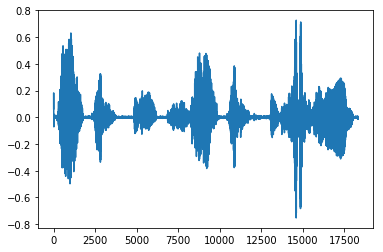

In [106]:
plt.plot(data)

In [107]:
# segment
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    min_level_db_floor=min_level_db_floor,
    db_delta=db_delta,
    ref_level_db=ref_level_db,
    pre=pre,
    min_silence_for_spec=min_silence_for_spec,
    max_vocal_for_spec=max_vocal_for_spec,
    min_level_db=min_level_db,
    silence_threshold=silence_threshold,
    verbose=True,
    min_syllable_length_s=min_syllable_length_s,
    spectral_range=spectral_range,
)

longest silence 0.04400000000000001
longest vocalization 0.20899999999999996


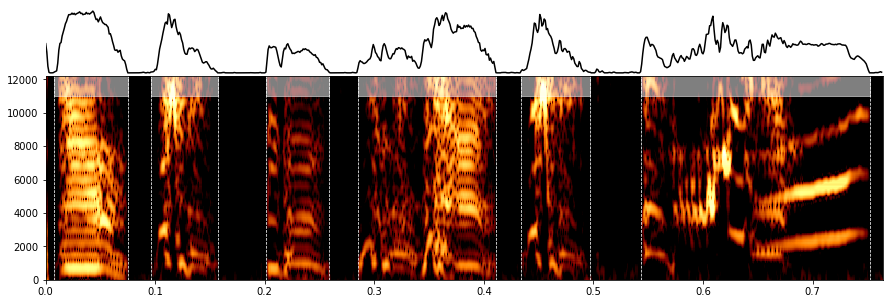

In [108]:
plot_segmentations(
    results["spec"],
    results["vocal_envelope"],
    results["onsets"],
    results["offsets"],
    hop_length_ms,
    rate,
    figsize=(15,5)
)
plt.show()

### segment and plot 
- for each json, load the wav file - segment the file into start and end times
- plot the segmentation
- add to the JSON 

In [109]:
import joblib

In [110]:
from avgn.utils.json import NoIndent, NoIndentEncoder

In [111]:
warnings.filterwarnings("ignore", message = "'tqdm_notebook' object has no attribute 'sp'")

def segment_spec_custom(key, df, save=False, plot=False):
    # load wav
    rate, data = load_wav(df.data["wav_loc"])
    # filter data
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)

    # segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        min_silence_for_spec=min_silence_for_spec,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=True,
        min_syllable_length_s=min_syllable_length_s,
        spectral_range=spectral_range,
    )
    if results is None:
        return
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
            figsize=(15, 3)
        )
        plt.show()

    # save the results
    json_out = DATA_DIR / "processed" / (DATASET_ID + "_segmented") / DT_ID / "JSON" / (
        key + ".JSON"
    )

    json_dict = df.data.copy()

    json_dict["indvs"][list(df.data["indvs"].keys())[0]]["syllables"] = {
        "start_times": NoIndent(list(results["onsets"])),
        "end_times": NoIndent(list(results["offsets"])),
    }

    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    # save json
    if save:
        ensure_dir(json_out.as_posix())
        print(json_txt, file=open(json_out.as_posix(), "w"))

    #print(json_txt)

    return results

In [112]:
indvs = np.array(['_'.join(list(i)) for i in dataset.json_indv])
np.unique(indvs)

array(['lny42', 'lny64', 'lr12', 'lr13', 'lr28', 'lr77'], dtype='<U5')

lny42


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


longest silence 0.04400000000000001
longest vocalization 0.20899999999999996


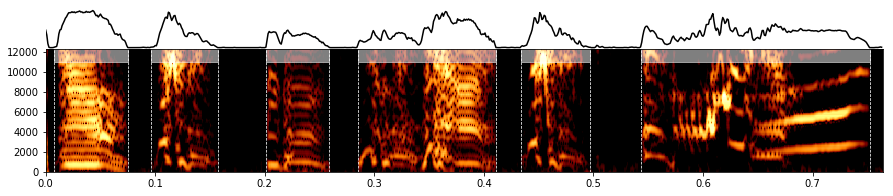

longest silence 0.033
longest vocalization 0.20699999999999996


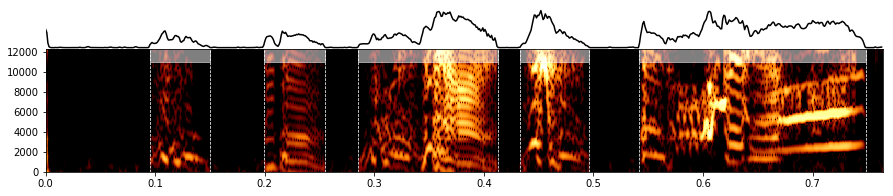

longest silence 0.027000000000000024
longest vocalization 0.20399999999999996


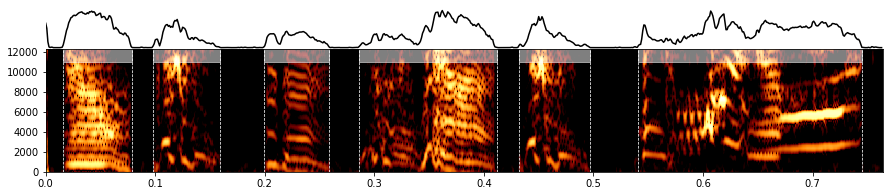

longest silence 0.04200000000000001
longest vocalization 0.20799999999999996


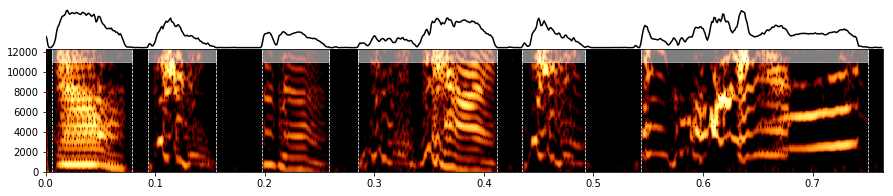

longest silence 0.027999999999999997
longest vocalization 0.21899999999999997


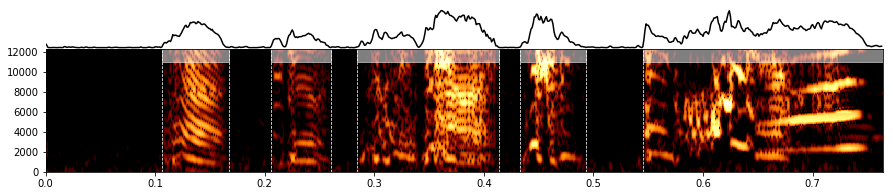

longest silence 0.040000000000000036
longest vocalization 0.20499999999999996


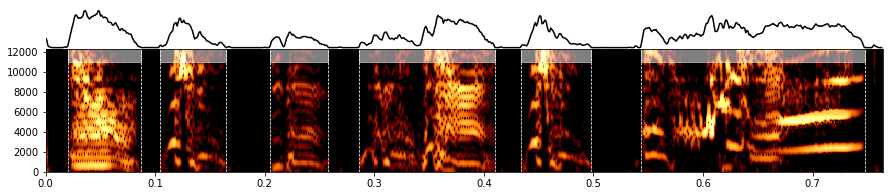

longest silence 0.02400000000000002
longest vocalization 0.20999999999999996


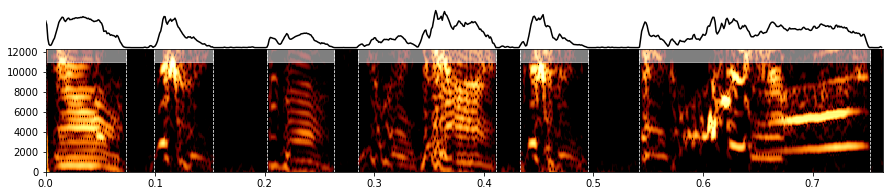

longest silence 0.041
longest vocalization 0.20999999999999996


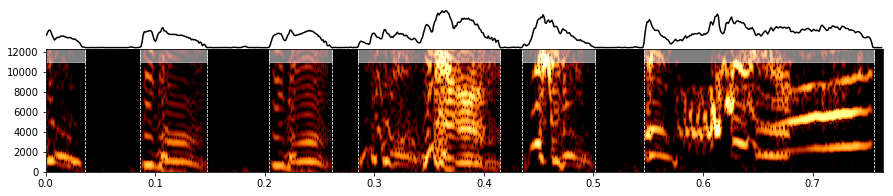

longest silence 0.04200000000000001
longest vocalization 0.20999999999999996


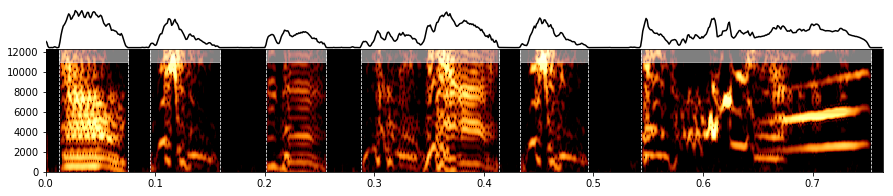

longest silence 0.035
longest vocalization 0.20999999999999996


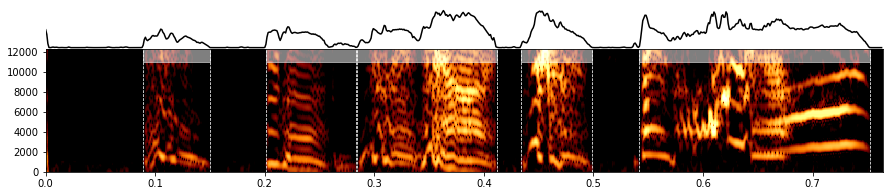

lny64


longest silence 0.02800000000000001
longest vocalization 0.135


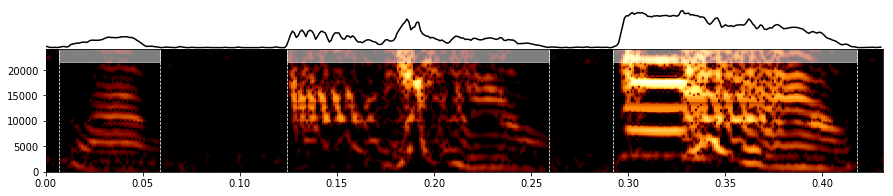

longest silence 0.024999999999999994
longest vocalization 0.136


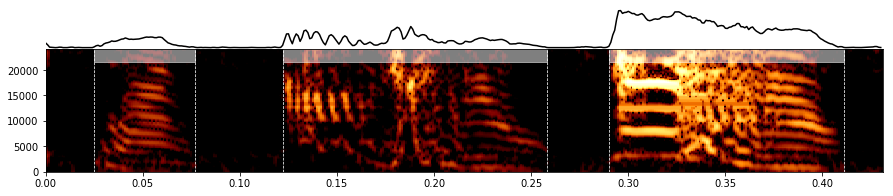

longest silence 0.043
longest vocalization 0.139


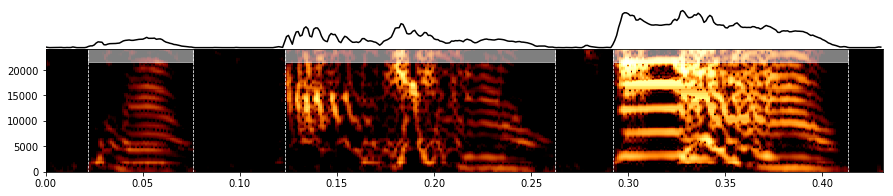

longest silence 0.015
longest vocalization 0.14400000000000002


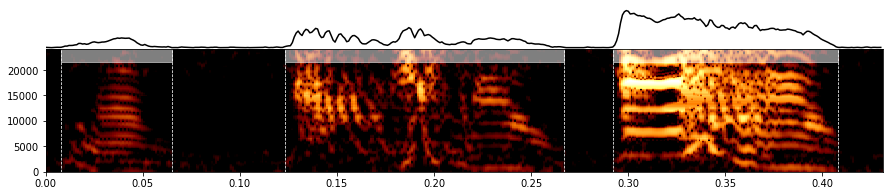

longest silence 0.015000000000000013
longest vocalization 0.14600000000000002


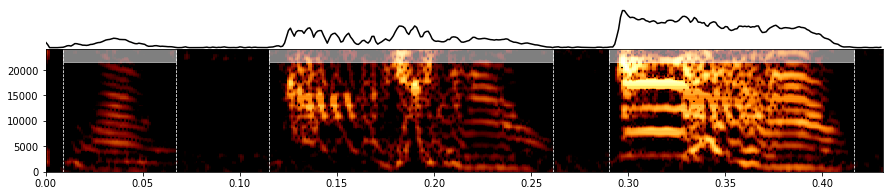

longest silence 0.019000000000000003
longest vocalization 0.131


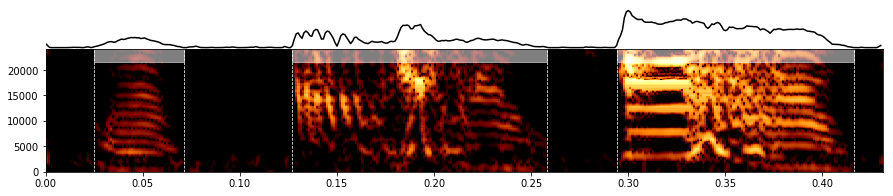

longest silence 0.028999999999999998
longest vocalization 0.14200000000000002


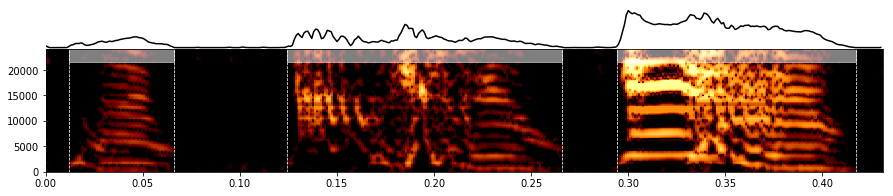

longest silence 0.04100000000000001
longest vocalization 0.14400000000000002


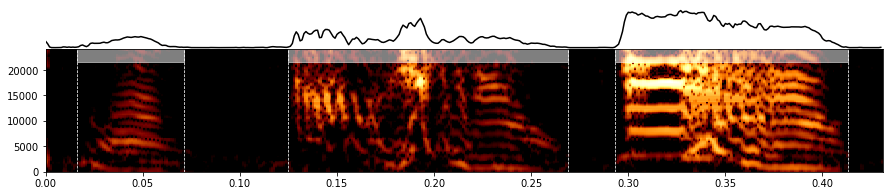

longest silence 0.026999999999999996
longest vocalization 0.14100000000000001


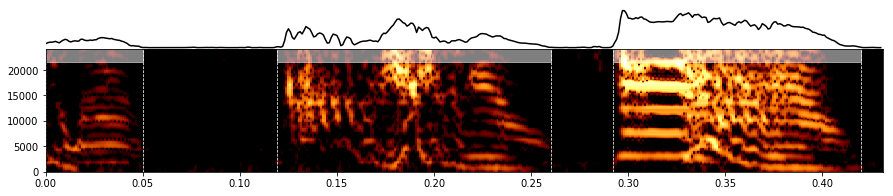

longest silence 0.018000000000000002
longest vocalization 0.139


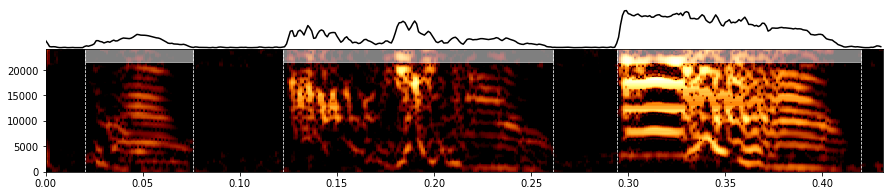

lr12


longest silence 0.010000000000000009
longest vocalization 0.145


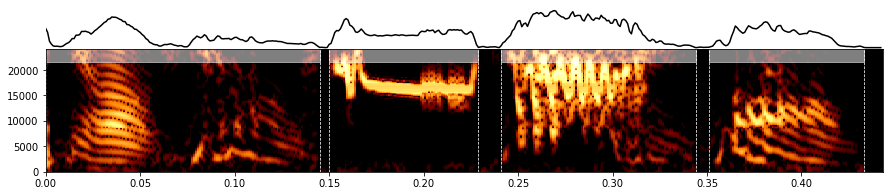

longest silence 0.015000000000000013
longest vocalization 0.145


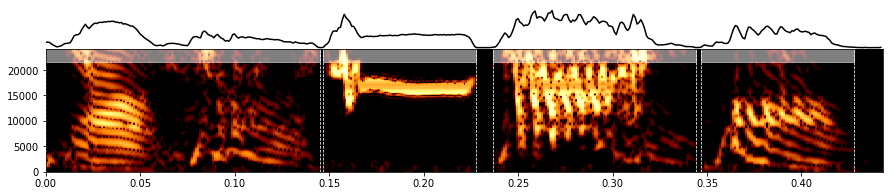

longest silence 0.01200000000000001
longest vocalization 0.147


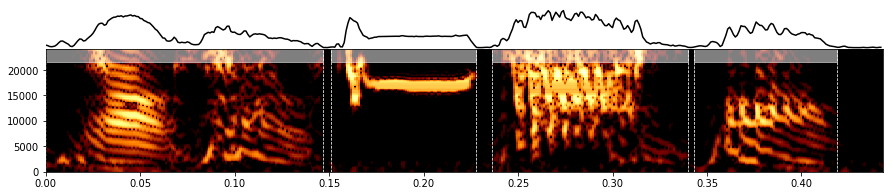

longest silence 0.017000000000000015
longest vocalization 0.147


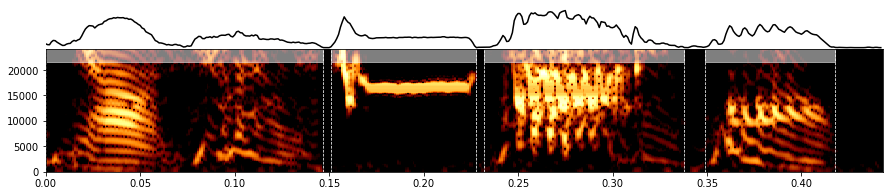

longest silence 0.007000000000000006
longest vocalization 0.181


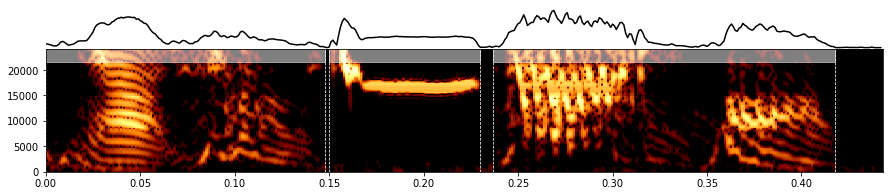

longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -120
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -115
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -110
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -105
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -100
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -95
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -90
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -85
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -80
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -75
longest silence 0.019000000000000017
longest vocalization 0.23
Current min_level_db: -70
longest silence 

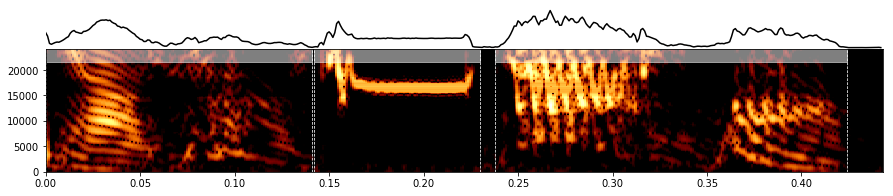

longest silence 0.010000000000000009
longest vocalization 0.19199999999999998


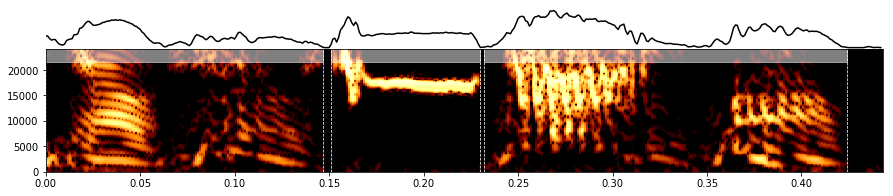

longest silence 0.01100000000000001
longest vocalization 0.19699999999999998


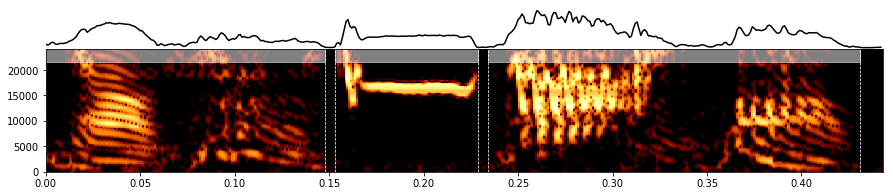

longest silence 0.013000000000000012
longest vocalization 0.13499999999999998


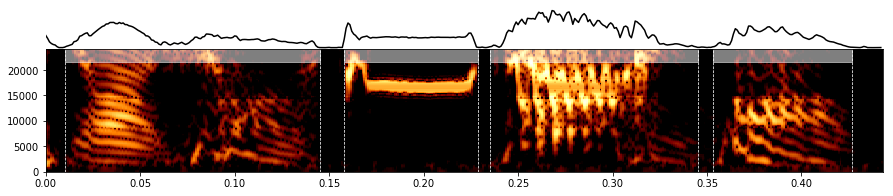

longest silence 0.018000000000000016
longest vocalization 0.148


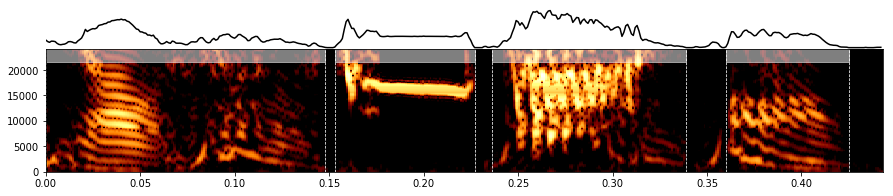

lr13


longest silence 0.018000000000000016
longest vocalization 0.182


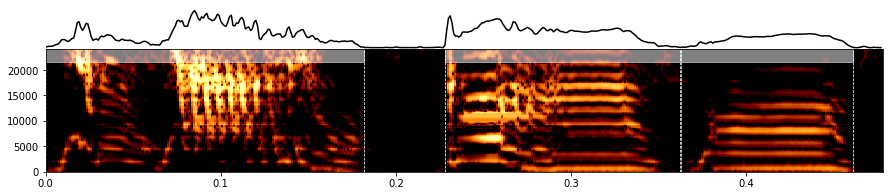

longest silence 0.04600000000000001
longest vocalization 0.183


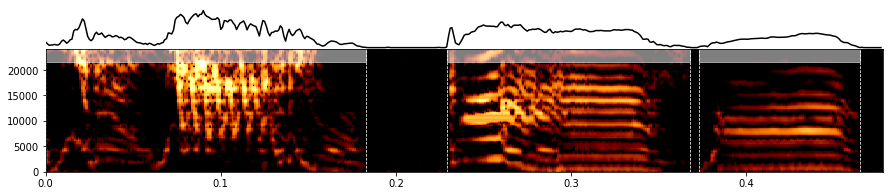

longest silence 0.017000000000000015
longest vocalization 0.186


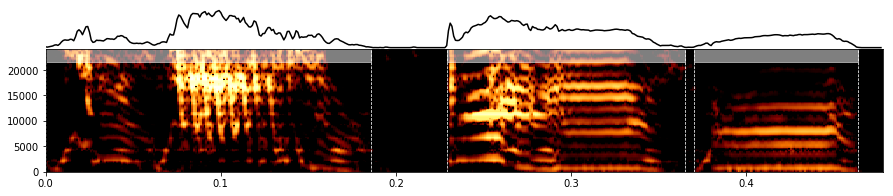

longest silence 0.04100000000000001
longest vocalization 0.176


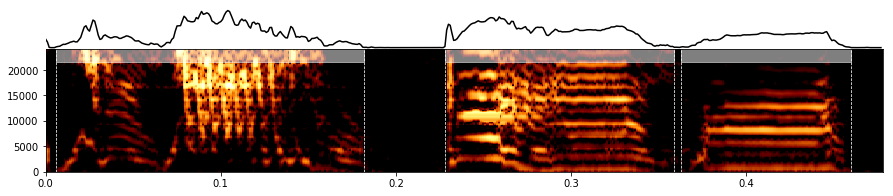

longest silence 0.026000000000000023
longest vocalization 0.183


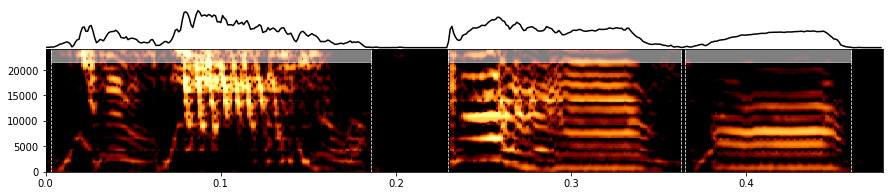

longest silence 0.01899999999999999
longest vocalization 0.188


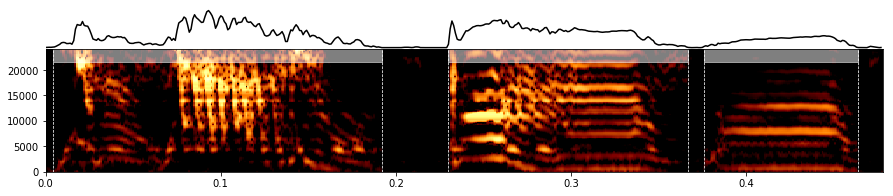

longest silence 0.017000000000000015
longest vocalization 0.186


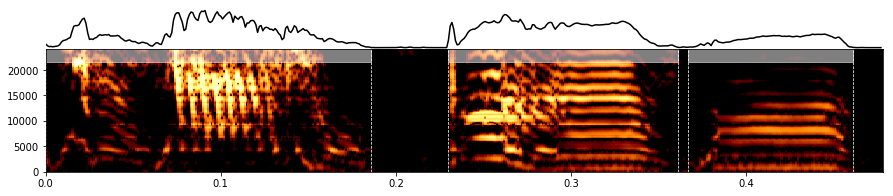

longest silence 0.04300000000000001
longest vocalization 0.179


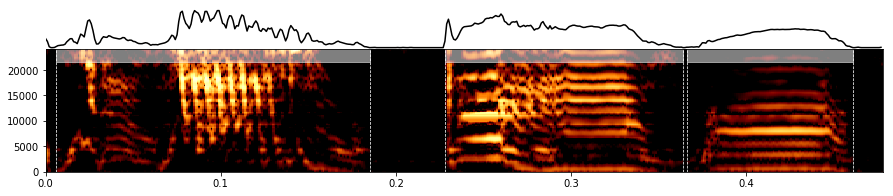

longest silence 0.024999999999999994
longest vocalization 0.184


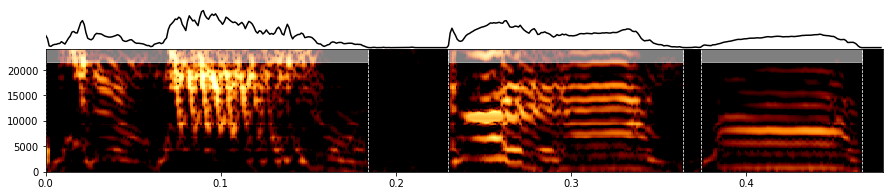

longest silence 0.03
longest vocalization 0.18


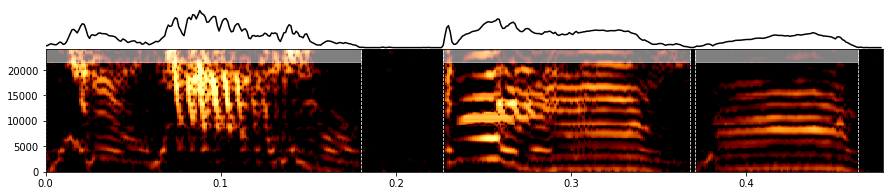

lr28


longest silence 0.015000000000000013
longest vocalization 0.131


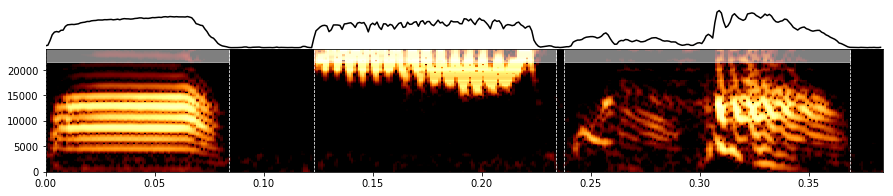

longest silence 0.024000000000000007
longest vocalization 0.12999999999999998


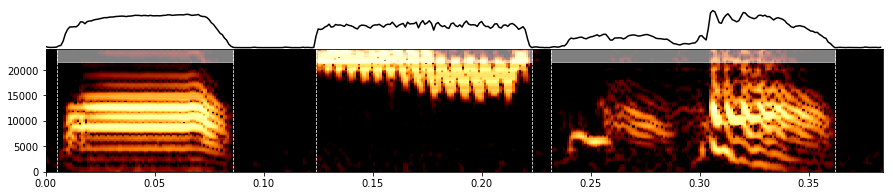

longest silence 0.01999999999999999
longest vocalization 0.132


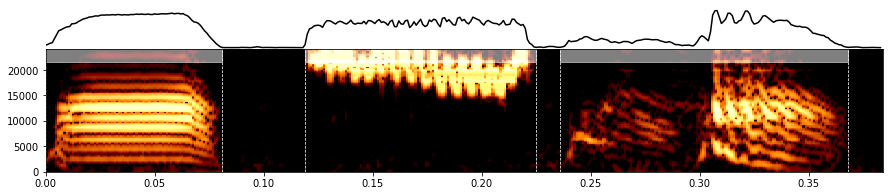

longest silence 0.011999999999999997
longest vocalization 0.132


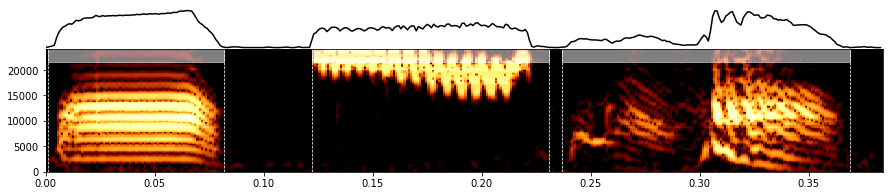

longest silence 0.018000000000000016
longest vocalization 0.13099999999999998


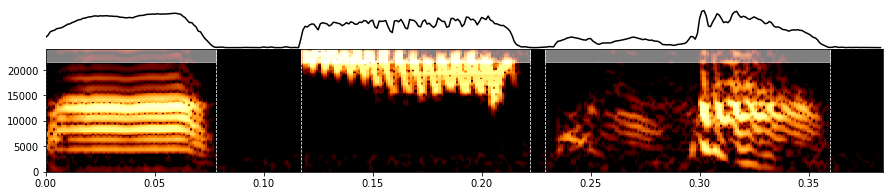

longest silence 0.015
longest vocalization 0.13699999999999998


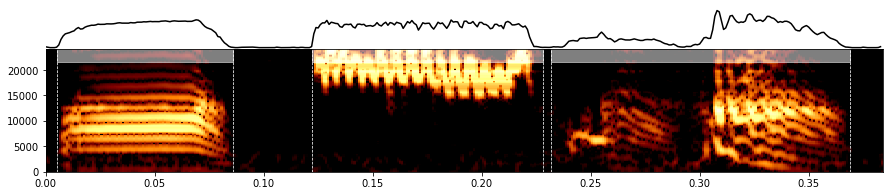

longest silence 0.027999999999999997
longest vocalization 0.131


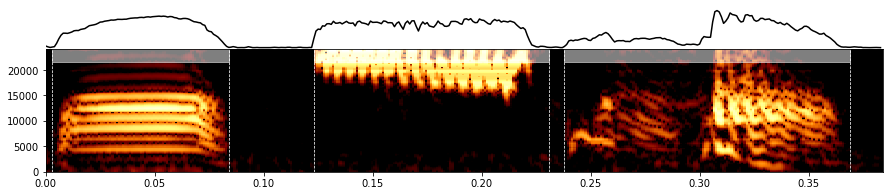

longest silence 0.007999999999999993
longest vocalization 0.134


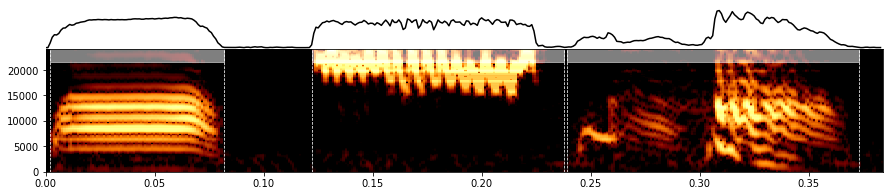

longest silence 0.03
longest vocalization 0.129


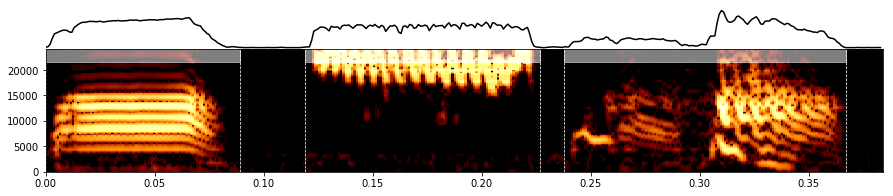

longest silence 0.008999999999999994
longest vocalization 0.13


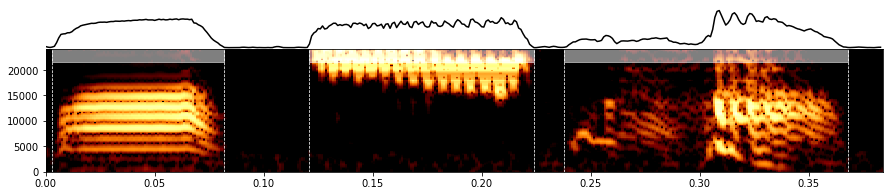

lr77


longest silence 0.014000000000000002
longest vocalization 0.14300000000000002


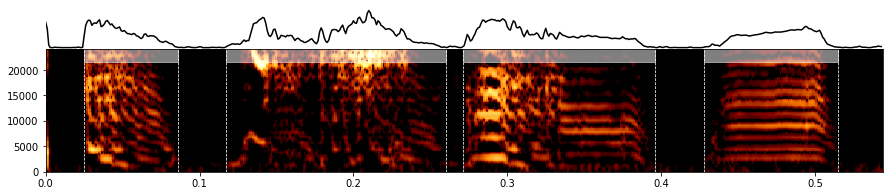

longest silence 0.028000000000000025
longest vocalization 0.15200000000000002


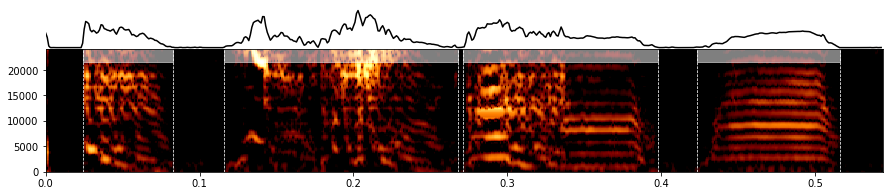

longest silence 0.02999999999999997
longest vocalization 0.14700000000000002


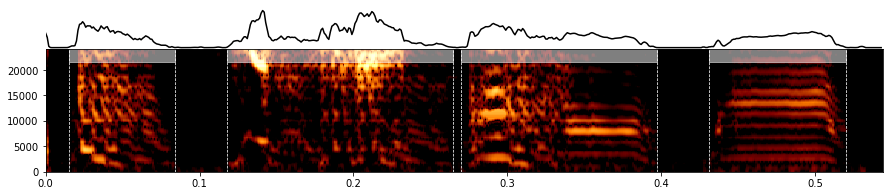

longest silence 0.023999999999999966
longest vocalization 0.135


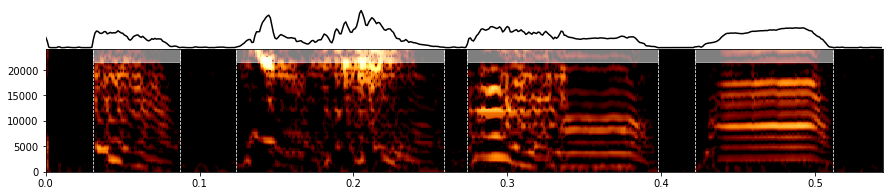

longest silence 0.028000000000000025
longest vocalization 0.139


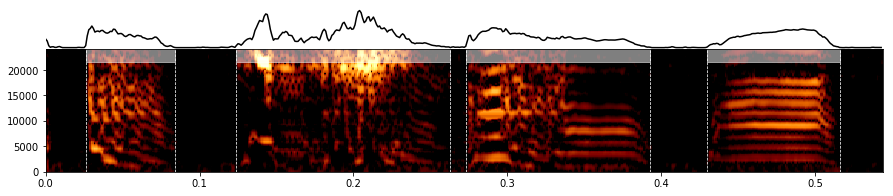

longest silence 0.01899999999999999
longest vocalization 0.14400000000000002


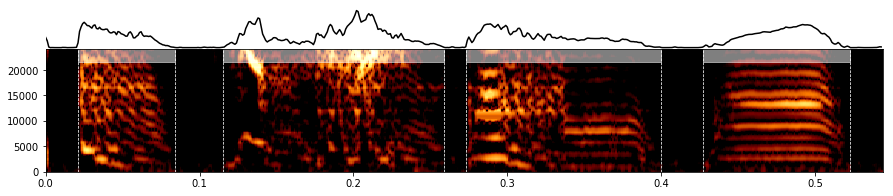

longest silence 0.035
longest vocalization 0.15900000000000003


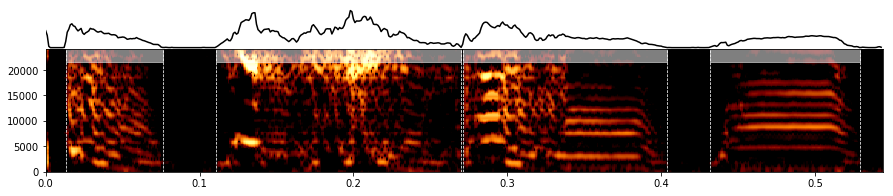

longest silence 0.02999999999999997
longest vocalization 0.14600000000000002


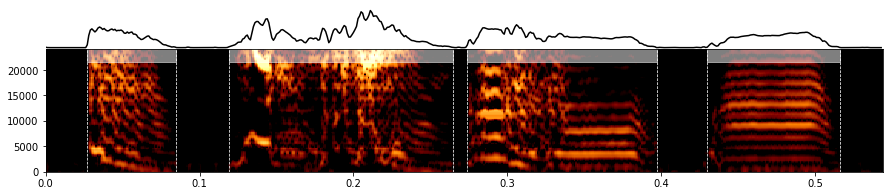

longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -120
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -115
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -110
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -105
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -100
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -95
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -90
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -85
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -80
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -75
longest silence 0.05299999999999999
longest vocalization 0.281
Current min_level_db: -70
longest silence 

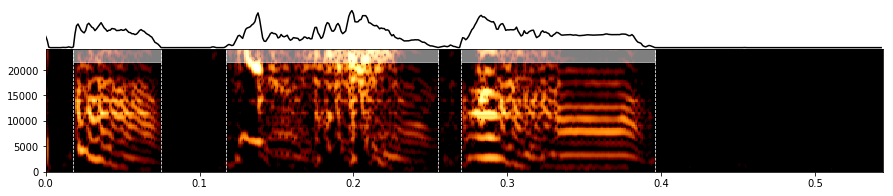

longest silence 0.034999999999999976
longest vocalization 0.139


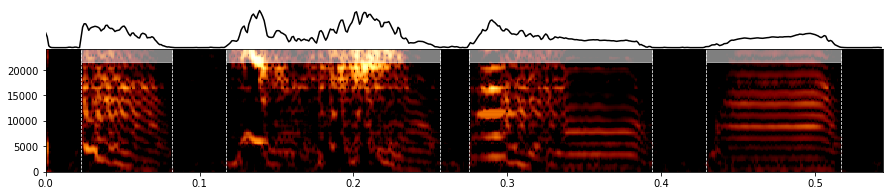

In [113]:
nex = 10
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=1, verbose=0)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], plot=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

### Generate for full dataset

In [114]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv]

    joblib.Parallel(n_jobs=-1, verbose=1)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], save=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

lny42


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   27.5s


lny64


[Parallel(n_jobs=-1)]: Done 2223 out of 2223 | elapsed:   30.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:    2.9s


lr12


[Parallel(n_jobs=-1)]: Done 2818 out of 2818 | elapsed:    5.1s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2172 tasks      | elapsed:    5.3s


lr13


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    7.0s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:    5.4s


lr28


[Parallel(n_jobs=-1)]: Done 2952 out of 2999 | elapsed:    6.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 2999 out of 2999 | elapsed:    6.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 880 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2880 tasks      | elapsed:    6.8s


lr77


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    8.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 912 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2412 tasks      | elapsed:    6.0s


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    7.2s finished
